# LSTM for Timeseries Prediction of 30P decay 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

### Opening data file

In [38]:
pd.options.mode.chained_assignment = None  # default='warn'
df = pd.read_csv("Decay.csv",index_col='Time')
df.index.freq='MS'
df.head()

,Number
Time,
0,792.891589
1,622.389565
2,486.717481
3,379.260561
4,301.300284


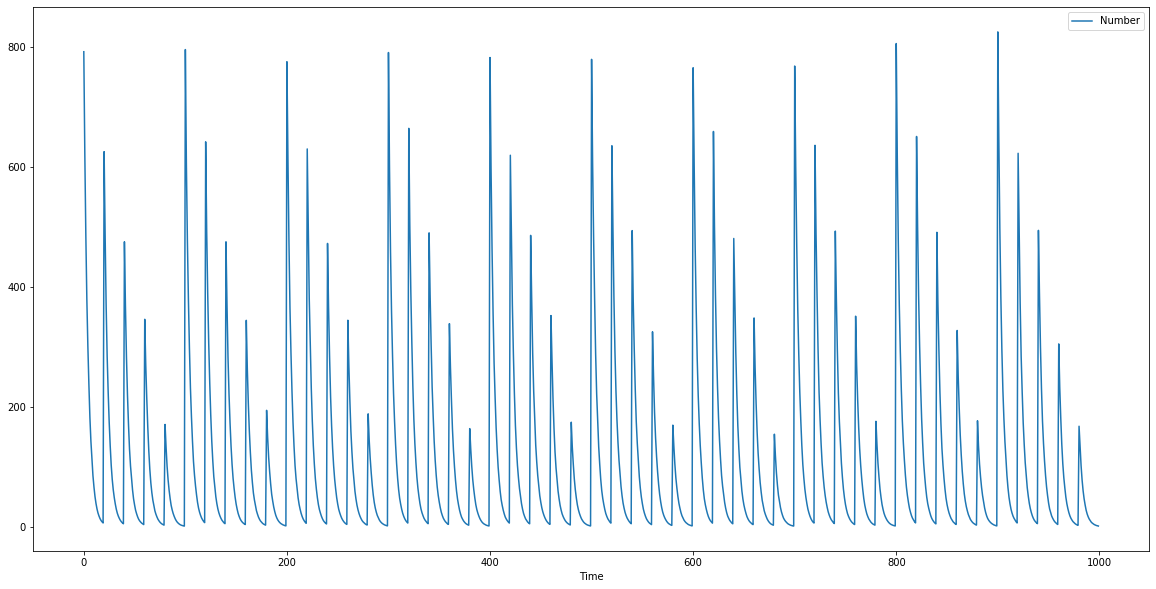

In [39]:
plt.rcParams["figure.figsize"] = (20,10)
df.plot()

### Seasonal Decomposition

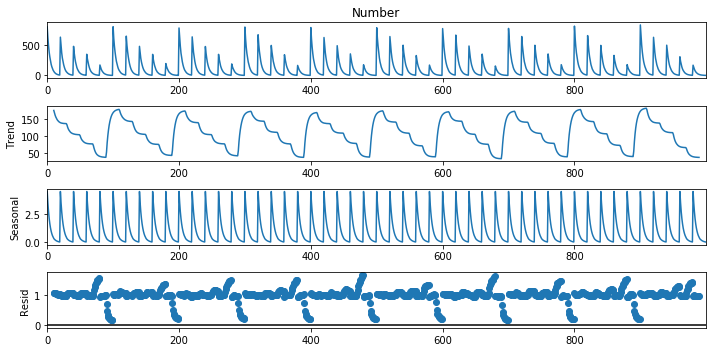

In [40]:
decomposed = seasonal_decompose(df['Number'],model='multiplicative',period=20)
plt.rcParams["figure.figsize"] = (10,5)
decomposed.plot();

### Preprocessing

In [41]:
#Making train and test data
df_train = df.iloc[:910]
df_test = df.iloc[910:]

#Preprocessing using MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1))
df_train[['Number']] = scaling.fit_transform(df_train[['Number']])
df_test

,Number
Time,
910,65.308008
911,49.676868
912,38.392261
913,29.457193
914,22.948472
...,...
995,3.758904
996,2.922708
997,2.232531


### Generator

In [42]:
n_input = 40
n_features = 1
generator = TimeseriesGenerator(df_train.values,df_train.values,length=n_input,batch_size=1)
#print(generator[0])

### Sequential Model

In [43]:
#Model
model = Sequential()
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.summary()

#Compile
#opt = Adam(lr=0.01)
model.compile(optimizer='adam', loss='mse')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


### Fitting

In [44]:
model.fit(generator,epochs=30)

Epoch 1/30
870/870 [==============================] - 17s 20ms/step - loss: 0.1980
Epoch 2/30
870/870 [==============================] - 16s 19ms/step - loss: 0.1123
Epoch 3/30
870/870 [==============================] - 17s 20ms/step - loss: 0.1106
Epoch 4/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0903
Epoch 5/30
870/870 [==============================] - 15s 18ms/step - loss: 0.0803
Epoch 6/30
870/870 [==============================] - 15s 18ms/step - loss: 0.0758
Epoch 7/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0763
Epoch 8/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0659
Epoch 9/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0594
Epoch 10/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0570
Epoch 11/30
870/870 [==============================] - 16s 18ms/step - loss: 0.0548
Epoch 12/30
870/870 [==============================] - 17s 19ms/step - loss: 0.0537
E

### Learning Curve

(0, 25)

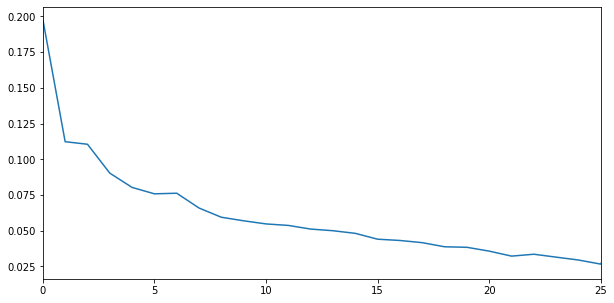

In [48]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.xlim(0,25)

### Testing

In [46]:
test_predictions = []
first_eval_batch = df_train[-n_input:]
current_batch = first_eval_batch.values.reshape((1, n_input, n_features))

for i in range(len(df_test)):
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    # append the prediction into the array
    test_predictions.append(current_pred) 
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions = scaling.inverse_transform(test_predictions)
df_test.loc[:,'Predicted Number'] = true_predictions

In [51]:
df_train[['Number']] = scaling.inverse_transform(df_train[['Number']])

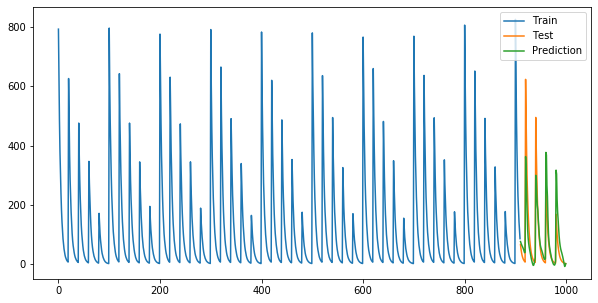

In [56]:
plt.plot(df_train['Number'],label='Train')
plt.plot(df_test['Number'],label='Test')
plt.plot(df_test['Predicted Number'],label='Prediction')
plt.legend()